* Project Overview

This Jupyter Notebook documents the analytical process undertaken to address the significant fresh food expiry and markdown losses experienced by FrischMarkt, a retail chain specializing in perishable goods. The project aims to leverage historical sales, inventory, and external data to build a demand forecasting model. The ultimate goal is to provide data-driven insights and actionable recommendations for optimizing inventory management, thereby reducing waste and improving the business's profitability.

For a struggling business, minimizing these losses is paramount. Our analysis will identify key drivers of demand, allowing for more precise ordering and a reduction in the substantial financial leakage currently impacting FrischMarkt.

## 1. Data Loading

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

# --- Configuration ---
# Define the directory where your generated CSV files are located
DATA_DIR = 'frischmarkt_data'

# --- 1. Data Loading ---
print("📊 Starting FrischMarkt Expiry Loss Analysis Project...")
print("-" * 50)
print("1. Loading Data...")

try:
    products_df = pd.read_csv(os.path.join(DATA_DIR, 'products_master.csv'))
    stores_df = pd.read_csv(os.path.join(DATA_DIR, 'stores_master.csv'))
    external_df = pd.read_csv(os.path.join(DATA_DIR, 'external_factors.csv'))
    inventory_df = pd.read_csv(os.path.join(DATA_DIR, 'inventory_daily.csv'))
    sales_df = pd.read_csv(os.path.join(DATA_DIR, 'sales_transactions.csv'))
    print("✅ All datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading data: {e}. Make sure you have run 'enhanced_frischgenerator.py' and the 'frischmarkt_data' directory exists with all CSVs.")
    # In a real notebook, you might use an assert or raise an error for hard stops
    # For this template, we'll print and continue, but in practice, data is essential.
    pass # Modified for notebook context, original exit() is for script execution

📊 Starting FrischMarkt Expiry Loss Analysis Project...
--------------------------------------------------
1. Loading Data...
✅ All datasets loaded successfully.


## 2. Data Inspection and Initial Preprocessing

After loading, it's crucial to inspect the data types, identify any missing values, and perform initial conversions. Date columns are converted to datetime objects for easier time-series analysis. Numeric columns are coerced to ensure correct types and NaN values are filled, typically with zeros for simplicity in this dataset

In [2]:
# --- 2. Data Inspection and Initial Preprocessing ---
print("\n2. Initial Data Inspection & Preprocessing...")

# Convert date columns to datetime objects for time-series analysis
for df in [external_df, inventory_df, sales_df]:
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])

# Display head and info for a quick check
print("\n--- Products Master Info ---")
print(products_df.info())
print("\n--- Stores Master Info ---")
print(stores_df.info())
print("\n--- External Factors Info ---")
print(external_df.info())
print("\n--- Inventory Daily Info ---")
print(inventory_df.info())
print("\n--- Sales Transactions Info ---")
print(sales_df.info())

# Ensure necessary columns are numeric and handle potential NaNs from merge operations later
for col in ['unit_cost', 'retail_price', 'shelf_life_days', 'base_expiry_rate', 'profit_margin']:
    if col in products_df.columns:
        products_df[col] = pd.to_numeric(products_df[col], errors='coerce').fillna(0)

for col in ['beginning_inventory', 'received_inventory', 'units_sold', 'units_expired', 'units_marked_down',
            'expiry_loss_eur', 'markdown_loss_eur', 'total_loss_eur', 'expiry_rate']:
    if col in inventory_df.columns:
        inventory_df[col] = pd.to_numeric(inventory_df[col], errors='coerce').fillna(0)

for col in ['quantity_sold', 'sale_price', 'discount_applied']:
    if col in sales_df.columns:
        sales_df[col] = pd.to_numeric(sales_df[col], errors='coerce').fillna(0)

print("\n✅ Data types converted and initial checks complete.")



2. Initial Data Inspection & Preprocessing...

--- Products Master Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             45 non-null     object 
 1   product_name           45 non-null     object 
 2   category               45 non-null     object 
 3   subcategory            45 non-null     object 
 4   brand                  45 non-null     object 
 5   unit_cost              45 non-null     float64
 6   retail_price           45 non-null     float64
 7   shelf_life_days        45 non-null     int64  
 8   mhd_vs_verbrauch       45 non-null     object 
 9   seasonality_factor     45 non-null     float64
 10  temperature_sensitive  45 non-null     bool   
 11  supplier_id            45 non-null     object 
 12  expiry_risk_level      45 non-null     object 
 13  base_expiry_rate       45 non-null 

## 3. Data Merging for Comprehensive Analysis

To facilitate a holistic analysis, especially for demand forecasting, various datasets are merged. The inventory_daily dataset serves as the base, enriched with product details from products_master, store information from stores_master, and daily external conditions from external_factors. The resulting demand_df will contain all necessary features for our predictive model.

In [3]:
# --- 3. Data Merging for Comprehensive Analysis ---
print("\n3. Merging Datasets...")

# Demand forecasting will use inventory_df as its base, as it already has units_sold per day per product per store
# Merge inventory data with product and store master data
demand_df = inventory_df.merge(products_df, on='product_id', how='left')
demand_df = demand_df.merge(stores_df, on='store_id', how='left')

# Merge with external factors
demand_df = demand_df.merge(external_df, on=['date', 'store_id'], how='left')

# Ensure units_sold is the primary sales metric at this level
# If units_sold in inventory_df differs from sum of sales_transactions for a given day/product/store,
# it might be necessary to aggregate sales_df first. For this simulated data, inventory_df's units_sold is sufficient.

print("✅ All relevant datasets merged into 'demand_df' for forecasting.")
print(f"\nShape of combined demand_df: {demand_df.shape}")
print(demand_df.head())


3. Merging Datasets...
✅ All relevant datasets merged into 'demand_df' for forecasting.

Shape of combined demand_df: (67392, 55)
        date store_id product_id  beginning_inventory  received_inventory  \
0 2023-01-02     S001       P040                    0                  69   
1 2023-01-03     S001       P040                   77                   0   
2 2023-01-04     S001       P040                   34                  56   
3 2023-01-05     S001       P040                   83                   0   
4 2023-01-06     S001       P040                    1                  87   

   units_sold  units_expired  units_marked_down  markdown_price markdown_date  \
0          61              0                  0             NaN           NaN   
1          38              5                  0             NaN           NaN   
2          62              1                  0             NaN           NaN   
3          76              6                  0             NaN           NaN   
4

##  4. Feature Engineering for Demand Forecasting

Feature engineering is critical for demand forecasting, especially with a single year of data. We create time-based features to capture seasonality and cyclical patterns within the year. Crucially, lagged sales features and rolling means are generated to provide the model with historical context of demand.

In [4]:
# --- 4. Feature Engineering for Demand Forecasting ---
print("\n4. Feature Engineering for Demand Forecasting...")

# Time-based features
demand_df['day_of_year'] = demand_df['date'].dt.dayofyear
demand_df['week_of_year'] = demand_df['date'].dt.isocalendar().week.astype(int)
demand_df['month'] = demand_df['date'].dt.month
demand_df['day_of_week_num'] = demand_df['date'].dt.dayofweek # Monday=0, Sunday=6

# Lagged sales features (CRUCIAL for time series with limited data)
# Sort by product, store, and date to ensure correct lags
demand_df = demand_df.sort_values(by=['product_id', 'store_id', 'date'])

# Lag 1 day and 7 days (previous week same day)
demand_df['units_sold_lag1'] = demand_df.groupby(['product_id', 'store_id'])['units_sold'].shift(1).fillna(0)
demand_df['units_sold_lag7'] = demand_df.groupby(['product_id', 'store_id'])['units_sold'].shift(7).fillna(0)
# Lag 30 days (previous month rough day)
demand_df['units_sold_lag30'] = demand_df.groupby(['product_id', 'store_id'])['units_sold'].shift(30).fillna(0)

# Rolling mean sales (e.g., average sales over the last 7 days)
demand_df['rolling_mean_sales_7d'] = demand_df.groupby(['product_id', 'store_id'])['units_sold'].transform(
    lambda x: x.shift(1).rolling(window=7, min_periods=1).mean()
).fillna(0)


# Convert boolean columns to integers (True=1, False=0)
for col in ['is_holiday', 'school_holidays', 'local_events', 'competitor_promotion',
            'heat_wave', 'power_outage_risk', 'delivery_disruption', 'temperature_sensitive']:
    if col in demand_df.columns:
        demand_df[col] = demand_df[col].astype(int)

print("✅ Feature engineering for demand forecasting complete.")
print(demand_df[['date', 'product_id', 'store_id', 'units_sold', 'units_sold_lag1', 'units_sold_lag7', 'rolling_mean_sales_7d']].head(10))



4. Feature Engineering for Demand Forecasting...
✅ Feature engineering for demand forecasting complete.
           date product_id store_id  units_sold  units_sold_lag1  \
7176 2023-01-02       P001     S001         100              0.0   
7177 2023-01-03       P001     S001          68            100.0   
7178 2023-01-04       P001     S001          88             68.0   
7179 2023-01-05       P001     S001          12             88.0   
7180 2023-01-06       P001     S001          23             12.0   
7181 2023-01-07       P001     S001          74             23.0   
7182 2023-01-09       P001     S001          61             74.0   
7183 2023-01-10       P001     S001          37             61.0   
7184 2023-01-11       P001     S001          51             37.0   
7185 2023-01-12       P001     S001          21             51.0   

      units_sold_lag7  rolling_mean_sales_7d  
7176              0.0               0.000000  
7177              0.0             100.000000  
7178 

## 5. Demand Forecasting Model for Inventory Optimization

This is the core of the predictive analysis. We build a RandomForestRegressor model to predict units_sold for each product-store combination on a given day. The data is split chronologically to simulate a real-world forecasting scenario, using the first 9 months for training and the last 3 months for testing.


--- Demand Forecasting Model for Inventory Optimization ---

Training data shape: (50544, 132), Testing data shape: (16848, 132)
Forecasting period: 2023-10-01 to 2023-12-30

Training RandomForestRegressor for demand forecasting...
✅ Demand forecasting model training complete.

--- Demand Forecasting Model Evaluation ---
Mean Absolute Error (MAE): 12.23 units
Mean Absolute Percentage Error (MAPE): 38.76%
R-squared (R2) Score: 0.6681
MAE indicates the average absolute difference between predicted and actual units sold.
R2 score represents the proportion of variance in units sold that can be predicted by the model.

--- Feature Importances (Top 15) for Demand Prediction ---
received_inventory       0.398385
beginning_inventory      0.193735
shelf_life_days          0.064182
rolling_mean_sales_7d    0.035988
units_sold_lag1          0.035763
units_sold_lag7          0.029312
units_sold_lag30         0.025008
temperature_high_c       0.016804
profit_margin            0.016716
temperature_

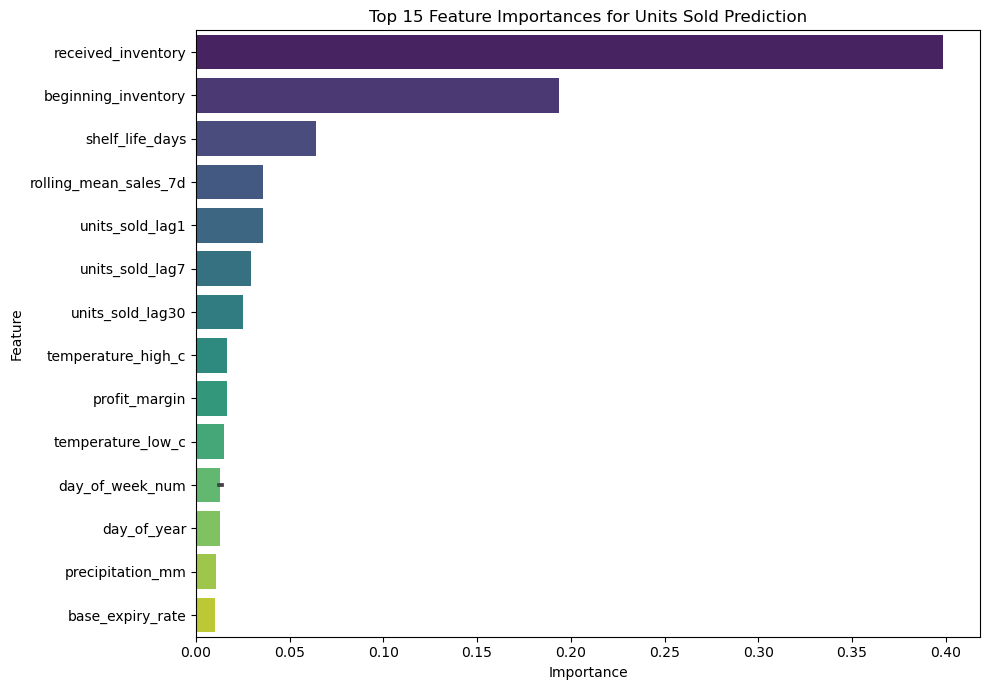

In [5]:
# --- 5. Demand Forecasting Model ---
print("\n--- Demand Forecasting Model for Inventory Optimization ---")

# Define features (X) and target (y)
# Include numerical features, engineered time features, and lagged sales
numerical_features = [
    'beginning_inventory', 'received_inventory', 'unit_cost', 'retail_price',
    'shelf_life_days', 'base_expiry_rate', 'profit_margin',
    'temperature_high_c', 'temperature_low_c', 'precipitation_mm', 'expiry_risk_multiplier',
    'demographics_score', 'refrigeration_capacity', 'staff_efficiency_score',
    'distance_from_warehouse_km', 'day_of_year', 'week_of_year', 'month', 'day_of_week_num',
    'units_sold_lag1', 'units_sold_lag7', 'units_sold_lag30', 'rolling_mean_sales_7d'
]

# Categorical features for one-hot encoding
categorical_features_for_model = [
    'category', 'subcategory', 'brand', 'location_type', 'foot_traffic_level',
    'management_quality', 'markdown_aggressiveness', 'day_of_week',
    'product_id', 'store_id' # Product and Store IDs are crucial for granular forecasting
]

# Boolean features (already converted to int)
boolean_features = [
    'is_holiday', 'school_holidays', 'local_events', 'competitor_promotion',
    'heat_wave', 'power_outage_risk', 'delivery_disruption', 'temperature_sensitive'
]

# Ensure all selected features exist in the DataFrame
all_features_to_include = numerical_features + categorical_features_for_model + boolean_features
for col in all_features_to_include:
    if col not in demand_df.columns:
        print(f"Warning: Feature '{col}' not found in demand_df. Skipping.")
        if col in numerical_features: numerical_features.remove(col)
        if col in categorical_features_for_model: categorical_features_for_model.remove(col)
        if col in boolean_features: boolean_features.remove(col)


# Create dummy variables for categorical features
demand_df_encoded = pd.get_dummies(demand_df, columns=categorical_features_for_model, drop_first=True)

# Combine all feature column names
X_cols = numerical_features + boolean_features + [col for col in demand_df_encoded.columns if any(col.startswith(f"{cat}_") for cat in categorical_features_for_model)]

# Filter X_cols to ensure only columns present in demand_df_encoded are used
X_cols = [col for col in X_cols if col in demand_df_encoded.columns]

X = demand_df_encoded[X_cols]
y = demand_df_encoded['units_sold']

# Handle any remaining NaNs in the feature set (e.g., from initial merges or lags)
X = X.fillna(0)
y = y.fillna(0) # Target variable should also not have NaNs

# Split the data into training and testing sets chronologically
# Given 1 year of data, use early part for training, later part for testing to simulate forecasting future.
split_date = demand_df['date'].max() - timedelta(days=90) # Last 3 months for testing

X_train = X[demand_df_encoded['date'] <= split_date]
y_train = y[demand_df_encoded['date'] <= split_date]

X_test = X[demand_df_encoded['date'] > split_date]
y_test = y[demand_df_encoded['date'] > split_date]

print(f"\nTraining data shape: {X_train.shape}, Testing data shape: {X_test.shape}")
print(f"Forecasting period: {split_date.strftime('%Y-%m-%d')} to {demand_df['date'].max().strftime('%Y-%m-%d')}")

# Initialize and train a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("\nTraining RandomForestRegressor for demand forecasting...")
model.fit(X_train, y_train)
print("✅ Demand forecasting model training complete.")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
# Avoid MAPE if y_test contains zeros, as it leads to division by zero.
# If zeros are common, use a robust alternative or filter them out for MAPE calculation.
# For simplicity, if MAPE is needed and zeros exist, filter for non-zero actuals.
mape = np.mean(np.abs((y_test - y_pred) / y_test.replace(0, np.nan))) * 100 # Replace 0s with NaN for MAPE to avoid division by zero
r2 = r2_score(y_test, y_pred)

print(f"\n--- Demand Forecasting Model Evaluation ---")
print(f"Mean Absolute Error (MAE): {mae:,.2f} units")
if not np.isnan(mape):
    print(f"Mean Absolute Percentage Error (MAPE): {mape:,.2f}%")
else:
    print("MAPE not calculated due to zero values in actuals. MAE is a better metric here.")
print(f"R-squared (R2) Score: {r2:.4f}")
print("MAE indicates the average absolute difference between predicted and actual units sold.")
print("R2 score represents the proportion of variance in units sold that can be predicted by the model.")

# Feature Importance for Demand Forecasting
print("\n--- Feature Importances (Top 15) for Demand Prediction ---")
if hasattr(model, 'feature_importances_'):
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    top_15_features = feature_importances.nlargest(15)
    print(top_15_features)

    plt.figure(figsize=(10, 7))
    sns.barplot(x=top_15_features.values, y=top_15_features.index, palette='viridis')
    plt.title('Top 15 Feature Importances for Units Sold Prediction')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("Feature importances not available for this model type.")